## 5.1 Single-Line

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pylab as plt

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

Generate the data:

In [2]:
def doppler(rv):
    beta = rv / c
    return np.sqrt((1. - beta) / (1. + beta))

def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / (sqrttwopi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    `rv`: radial velocity in m/s (or same units as `c` above
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    --
    We take the view that lines multiply into the spectrum.
    """
    lnsynths = np.zeros_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        lnsynths += (d * oned_gaussian(xs * doppler(rv), m, sig))
    return np.exp(lnsynths)

def make_data(N, xs, ds, ms, sigs, snr=100.):
    """
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = snr**2.
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [3]:
ds = [-0.05, ] # EW units (A), sort-of
ms = [5000.0, ] # A
sigs = [0.05, ] # A
dx = 0.01 # A
xs = np.arange(4992. + 0.5 * dx, 5008., dx) # A
N = 64
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)

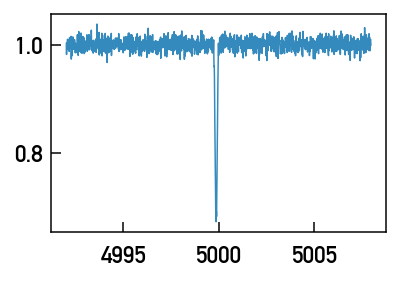

In [4]:
plt.plot(xs, data[0])

Calculate CRLB:

In [5]:
def dsynth_dv(rv, xs, ds, ms, sigs):
    dv = 10. # m/s
    f2 = make_synth(rv + dv, xs, ds, ms, sigs)
    f1 = make_synth(rv - dv, xs, ds, ms, sigs)
    return (f2 - f1) / (2. * dv)

def calc_crlb(xs, ds, ms, sigs, N, ivars):
    dmodel_dv = dsynth_dv(0., xs, ds, ms, sigs)
    crlbs = np.zeros(N)
    for n in range(N): # average CRLB; averaging over true RV
        crlbs[n] = np.sum(dmodel_dv * ivars[n, :] * dmodel_dv)
    crlb = 1. / np.sqrt(np.mean(crlbs))
    return crlb

In [6]:
crlb = calc_crlb(xs, ds, ms, sigs, N, ivars)
print("CRLB:", crlb, "m/s")

('CRLB:', 43.952624218983679, 'm/s')


# How does the CRLB change as line FWHM changes?

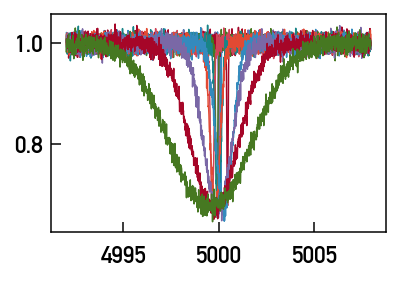

In [17]:
all_sigs = np.logspace(-2, 0.3, 101)
all_ds = -0.05/0.05 * all_sigs
all_fwhms = 2. * np.sqrt(2. * np.log(2.)) * all_sigs
crlbs = np.zeros_like(all_sigs)
for i,(sig,d) in enumerate(zip(all_sigs, all_ds)):
    sigs[0] = sig
    ds[0] = d
    data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)
    crlbs[i] = calc_crlb(xs, ds, ms, sigs, N, ivars)
    if (i % 10) == 0:
        plt.plot(xs, data[0])
sigs = [0.05, ] # A
ds = [-0.05, ] # A

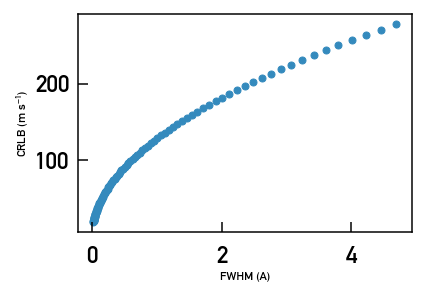

In [18]:
plt.scatter(all_fwhms, crlbs)
#par = np.polyfit(all_fwhms, crlbs, 1) # fit a line
#plt.plot(all_fwhms, np.polyval(par, all_fwhms), c='r')
plt.xlabel('FWHM (A)')
plt.ylabel(r'CRLB (m s$^{-1}$)')

In [19]:
# linear fitting of a sqrt
A = np.sqrt(all_fwhms)
ATA = np.dot(A, A)
ATy = np.dot(A, crlbs)
amp = ATy / ATA

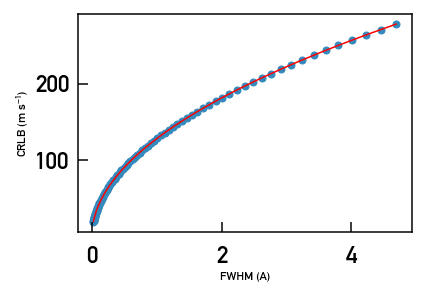

In [20]:
plt.scatter(all_fwhms, crlbs)
plt.plot(all_fwhms, amp * A, c='r')
plt.xlabel('FWHM (A)')
plt.ylabel(r'CRLB (m s$^{-1}$)')

# How does CRLB change as contrast changes?

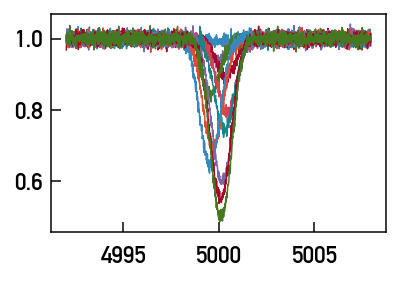

In [50]:
all_cs = np.linspace(0.01, 0.5, 101)
all_sigs = np.zeros_like(all_cs) + 0.5
all_ds = np.log(1. - all_cs) * all_sigs * sqrttwopi # trust us
crlbs = np.zeros_like(all_cs)
for i,(d,sig) in enumerate(zip(all_ds,all_sigs)):
    ds[0] = d
    sigs[0] = sig
    data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)
    crlbs[i] = calc_crlb(xs, ds, ms, sigs, N, ivars)
    if (i % 10) == 0:
        plt.plot(xs, data[0])
        #print N, xs, ds, ms, sigs
sigs = [0.05, ] # A
ds = [0.15, ] # A

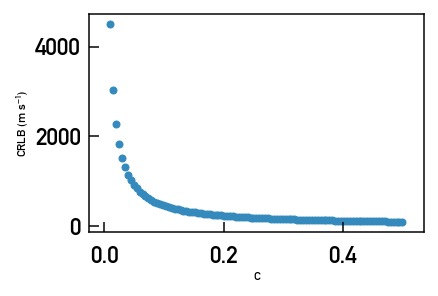

In [51]:
plt.scatter(all_cs, crlbs)
plt.xlabel('C')
plt.ylabel(r'CRLB (m s$^{-1}$)')

In [52]:
# linear fitting of a 1/linear
A = 1.0/all_cs
ATA = np.dot(A, A)
ATy = np.dot(A, crlbs)
amp = ATy / ATA

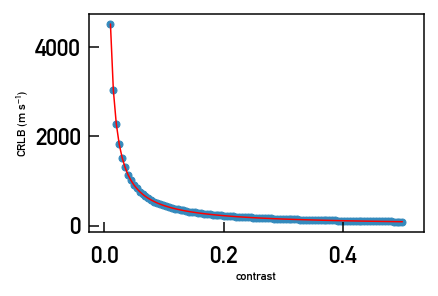

In [53]:
plt.scatter(all_cs, crlbs)
plt.plot(all_cs, amp * A, c='r')
plt.xlabel('contrast')
plt.ylabel(r'CRLB (m s$^{-1}$)')